In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import Dataset
import os
from PIL import Image
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
my_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Alzheimer_s Dataset/train', transform=my_transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Alzheimer_s Dataset/test', transform=my_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Pretrained VGG16 model as base
        self.base_model = models.vgg16(pretrained=False)
        
        # Remove the last layer of the base model
        self.base_model.classifier = nn.Identity()
        
        # Add custom classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.BatchNorm1d(25088),
            nn.Linear(25088, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 4),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

net = Net()

In [ ]:
net

Net(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Train the model
for epoch in range(50):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

# Evaluate the model
net.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for j,(inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels += predicted.tolist()
        true_labels += labels.tolist()

    print('Accuracy: {:.2f}%'.format(100 * correct / total))


# Convert the predicted and true labels to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

Epoch 1 loss: 1.208
Accuracy: 22.44%


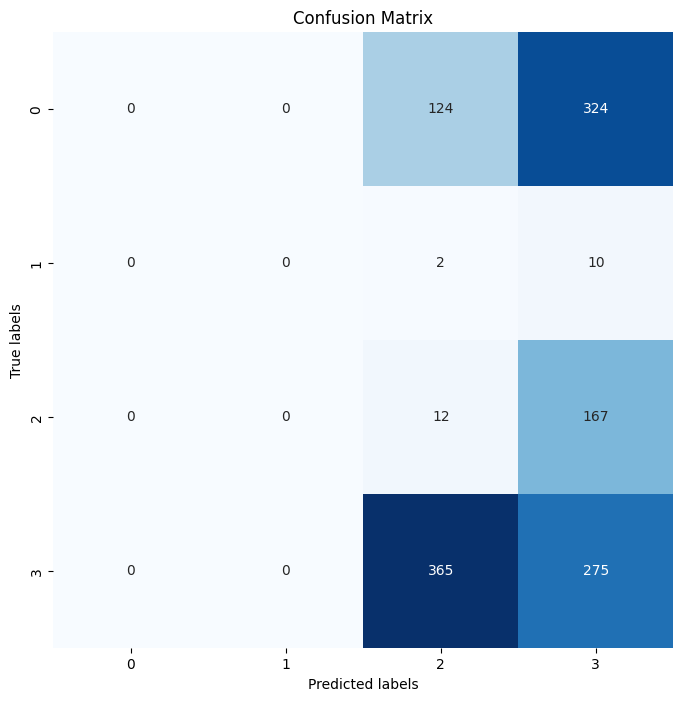

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true_labels, predicted_labels)


# plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(['class1', 'class2', 'class3', 'class4'])
#ax.yaxis.set_ticklabels(['class1', 'class2', 'class3', 'class4'])
plt.savefig('matrixv.png')
plt.show()